In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import sklearn.model_selection as model_selection
import seaborn as sns
import math

# Descripción

census_data_income = pd.read_csv('adult.csv')

In [7]:
census_data_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


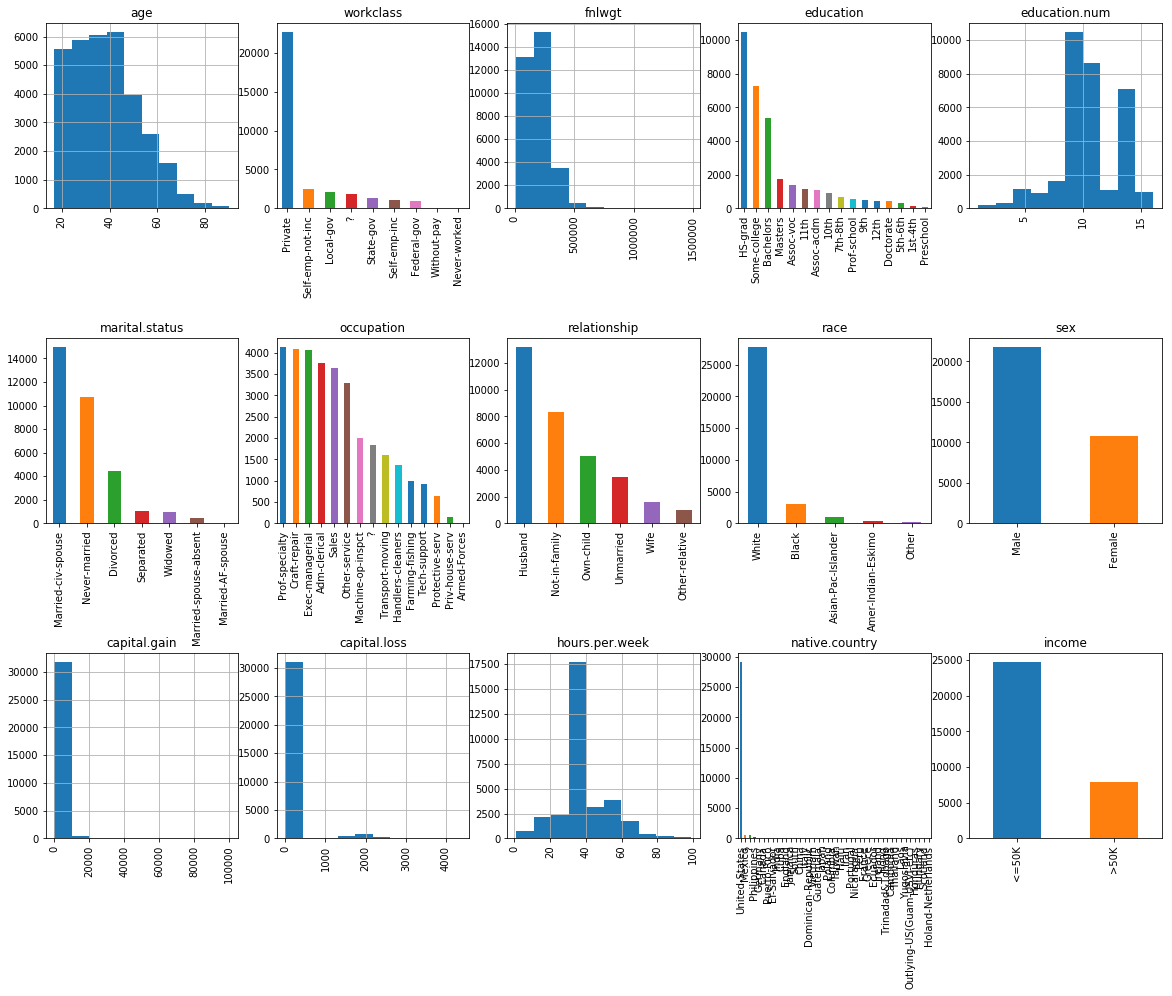

In [10]:
import matplotlib.pyplot as plt

# fuente: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(census_data_income.shape[1]) / cols)
for i, column in enumerate(census_data_income.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if census_data_income.dtypes[column] == np.object:
        census_data_income[column].value_counts().plot(kind="bar", axes=ax)
    else:
        census_data_income[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [18]:
# Confirmar el sesgo en la data (según las distribuciones generadas
# 'fnlwgt', 'capital.gain' y 'capital.loss' están altamente sesgadas.)

census_data_income.skew()

# Confirma lo observado en las distribuciones; la variable target 'income'
# también está sesgada.

age                0.558743
fnlwgt             1.446980
education.num     -0.311676
capital.gain      11.953848
capital.loss       4.594629
hours.per.week     0.227643
income             1.212430
dtype: float64

# Pre-procesamiento de la data

In [11]:
# Convertir '<=50K' a 0 y '>50K' a 1.

data = census_data_income
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

In [12]:
# Reemplazar los valores que no se conocen, ?, por la moda.

data = data.replace({'workclass':{'?' : 'Private'}})
data = data.replace({'occupation':{'?' : 'Prof-specialty'}})

In [13]:
# Descatar 'education' porque contiene la misma información que 'education.num'

data = data.drop('education',1)
data.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,Private,186061,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [14]:
# Convertir todos los valores de variables categóricas a dummies
data_d = pd.get_dummies(data)
data_d.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,90,77053,9,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,82,132870,9,0,4356,18,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,66,186061,10,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,54,140359,4,0,3900,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,41,264663,10,0,3900,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


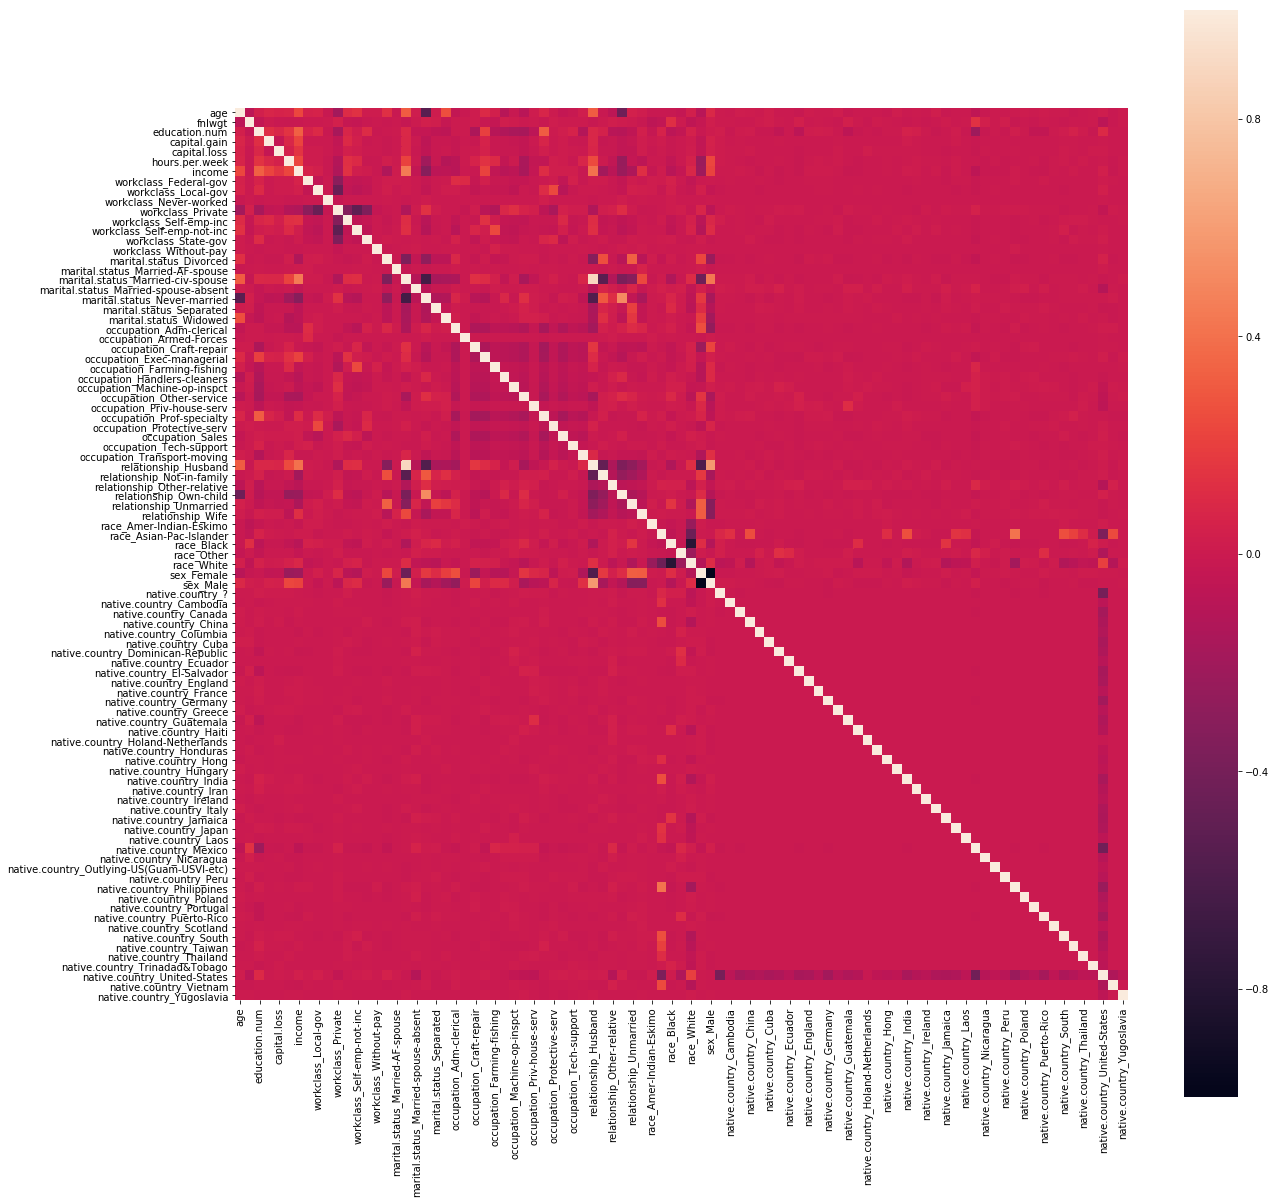

In [35]:
# Verificar correlación

data_corr = data_d.corr()


# fuente: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/
plt.subplots(figsize=(20,20))
sns.heatmap(data_corr, square=True)
plt.show()

# Conjuntos de entrenamiento y prueba

In [41]:
from sklearn.model_selection import train_test_split

X = data_d.drop('income',1)
y = data_d['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
print ('Entrenamiento: ', len(y_train))
print ('Prueba: ', len(y_test))

Entrenamiento:  26048
Prueba:  6513


# Definición de matriz de confusión

In [52]:
# Del cuadernillo "Evaluación de Aprendizaje"

def matrizC(y_test, predicciones_test):
    matriz_confusion = metrics.confusion_matrix(y_test, predicciones_test)

    # Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    TN = matriz_confusion[0,0]
    FN = matriz_confusion[1,0]
    FP = matriz_confusion[0,1]
    TP = matriz_confusion[1,1]

    print ('              +-----------------+')
    print ('              |   Predicción    |')
    print ('              +-----------------+')
    print ('              |    +   |    -   |')
    print ('+-------+-----+--------+--------+')
    print ('| Valor |  +  |   %d |   %d   |'   % (TP, FN) )
    print ('| real  +-----+--------+--------+')
    print ('|       |  -  |   %d  |   %d  |'    % (FP, TN) )
    print ('+-------+-----+--------+--------+')
    print ()
    print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

# DecisionTreeClassifier

In [109]:
# Entrenar el modelo (primer intento)

from sklearn.tree import DecisionTreeClassifier

m = DecisionTreeClassifier(random_state=0)
m.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [55]:
# Obtener predicciones para el primer intento

predicciones_test = m.predict(X_test)

In [59]:
# Obtener matriz de confusión para el primer intento

matrizC(y_test, predicciones_test)

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   953 |   594   |
| real  +-----+--------+--------+
|       |  -  |   614  |   4352  |
+-------+-----+--------+--------+

Exactitud    :  0.8145247965607247


0.8145247965607247

In [57]:
# Calcular área bajo la curva ROC para el primer intento

from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7461951353235615

In [114]:
# Probar con diferentes valores de max depth

max_depths = np.linspace(1,20,20, endpoint = True)

resultados_entrenamiento_exactitud = []
resultados_prueba_exactitud = []

resultados_entrenamiento_roc_auc = []
resultados_prueba_roc_auc = []

score_mejor = 0

for max_depth in max_depths:
    m = DecisionTreeClassifier(max_depth = max_depth, random_state=0)
    m.fit(X_train, y_train)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de entrenamiento
    
    predicciones_entrenamiento = m.predict(X_train)
    
    exactitud = metrics.accuracy_score(y_train, predicciones_entrenamiento)
    
    resultados_entrenamiento_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicciones_entrenamiento)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_entrenamiento_roc_auc.append(roc_auc)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de prueba
    
    predicciones_prueba = m.predict(X_test)
    
    exactitud = metrics.accuracy_score(y_test, predicciones_prueba)
    
    resultados_prueba_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_prueba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_prueba_roc_auc.append(roc_auc)
    
    scoredt = m.score(X_test, y_test)
    if scoredt > score_mejor: 
        score_mejor = scoredt
        max_depth_mejor = max_depth
    

print('El mejor score de', score_mejor, 'corresponde a una profundida de', max_depth_mejor)

El mejor score de 0.8539843390142792 corresponde a una profundida de 12.0


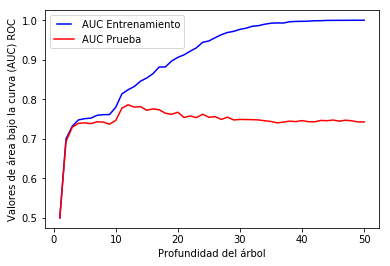

El máximo valor de área bajo la curva ROC de 0.7860899494715324 en el conjunto de pruebas corresponde a una profundida de 12.0


In [112]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, resultados_entrenamiento_roc_auc, 'b', label="AUC Entrenamiento")
line2, = plt.plot(max_depths, resultados_prueba_roc_auc, 'r', label="AUC Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de área bajo la curva (AUC) ROC')
plt.xlabel('Profundidad del árbol')
plt.show()

maximo_auc = max(resultados_prueba_roc_auc)
indice_max_auc = resultados_prueba_roc_auc.index(maximo_auc)

print('El máximo valor de área bajo la curva ROC de', max(resultados_prueba_roc_auc), 'en el conjunto de pruebas corresponde a una profundida de', max_depths[indice_max_auc])

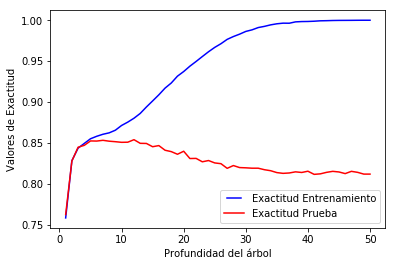

La máxima exactitud de 0.8539843390142792 en el conjunto de pruebas corresponde a una profundida de 12.0


In [113]:
line1, = plt.plot(max_depths, resultados_entrenamiento_exactitud, 'b', label="Exactitud Entrenamiento")
line2, = plt.plot(max_depths, resultados_prueba_exactitud, 'r', label="Exactitud Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de Exactitud')
plt.xlabel('Profundidad del árbol')
plt.show()

maximo_e = max(resultados_prueba_exactitud)
indice_max_e = resultados_prueba_exactitud.index(maximo_e)

print('La máxima exactitud de', max(resultados_prueba_exactitud), 'en el conjunto de pruebas corresponde a una profundida de', max_depths[indice_max_e])

El mejor score de 0.8564409642253954 corresponde a un min_samples_split de 44


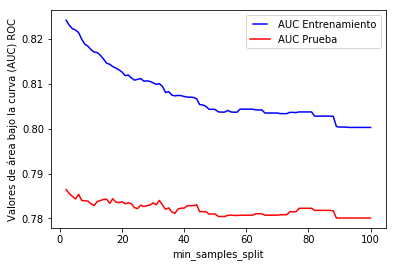

El máximo valor de área bajo la curva ROC de 0.7864131556770916 en el conjunto de pruebas corresponde a un min_samples_split de 2


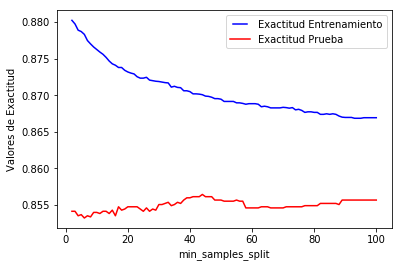

La máxima exactitud de 0.8564409642253954 en el conjunto de pruebas corresponde a un min_samples_split de 44


In [116]:
# Probar con diferentes valores de min_samples_split

min_samples_splits = np.linspace(2,100,99, dtype = int, endpoint = True)

resultados_entrenamiento_exactitud = []
resultados_prueba_exactitud = []

resultados_entrenamiento_roc_auc = []
resultados_prueba_roc_auc = []

score_mejor = 0

for min_samples_split in min_samples_splits:
    m = DecisionTreeClassifier(min_samples_split = min_samples_split, max_depth = 12, random_state=0)
    m.fit(X_train, y_train)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de entrenamiento
    
    predicciones_entrenamiento = m.predict(X_train)
    
    exactitud = metrics.accuracy_score(y_train, predicciones_entrenamiento)
    
    resultados_entrenamiento_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicciones_entrenamiento)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_entrenamiento_roc_auc.append(roc_auc)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de prueba
    
    predicciones_prueba = m.predict(X_test)
    
    exactitud = metrics.accuracy_score(y_test, predicciones_prueba)
    
    resultados_prueba_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_prueba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_prueba_roc_auc.append(roc_auc)
    
    scoredt = m.score(X_test, y_test)
    if scoredt > score_mejor: 
        score_mejor = scoredt
        min_samples_split_mejor = min_samples_split

print('El mejor score de', score_mejor, 'corresponde a un min_samples_split de', min_samples_split_mejor)

line1, = plt.plot(min_samples_splits, resultados_entrenamiento_roc_auc, 'b', label="AUC Entrenamiento")
line2, = plt.plot(min_samples_splits, resultados_prueba_roc_auc, 'r', label="AUC Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de área bajo la curva (AUC) ROC')
plt.xlabel('min_samples_split')
plt.show()

maximo_auc = max(resultados_prueba_roc_auc)
indice_max_auc = resultados_prueba_roc_auc.index(maximo_auc)

print('El máximo valor de área bajo la curva ROC de', max(resultados_prueba_roc_auc), 'en el conjunto de pruebas corresponde a un min_samples_split de', min_samples_splits[indice_max_auc])

line1, = plt.plot(min_samples_splits, resultados_entrenamiento_exactitud, 'b', label="Exactitud Entrenamiento")
line2, = plt.plot(min_samples_splits, resultados_prueba_exactitud, 'r', label="Exactitud Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de Exactitud')
plt.xlabel('min_samples_split')
plt.show()

maximo_e = max(resultados_prueba_exactitud)
indice_max_e = resultados_prueba_exactitud.index(maximo_e)

print('La máxima exactitud de', max(resultados_prueba_exactitud), 'en el conjunto de pruebas corresponde a un min_samples_split de', min_samples_splits[indice_max_e])

El mejor score de 0.8581298940580377 corresponde a un min_samples_leaf de 51


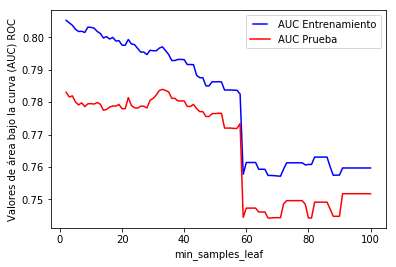

El máximo valor de área bajo la curva ROC de 0.7839552655536639 en el conjunto de pruebas corresponde a un min_samples_leaf de 33


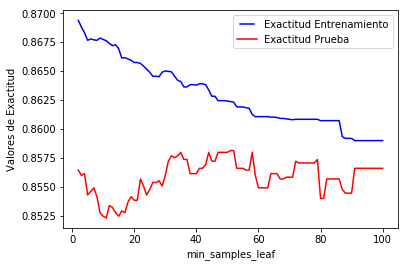

La máxima exactitud de 0.8581298940580377 en el conjunto de pruebas corresponde a un min_samples_leaf de 51


In [117]:
# Probar con diferentes valores de min_samples_leaf

min_samples_leafs = np.linspace(2,100,99, dtype = int, endpoint = True)

resultados_entrenamiento_exactitud = []
resultados_prueba_exactitud = []

resultados_entrenamiento_roc_auc = []
resultados_prueba_roc_auc = []

score_mejor = 0

for min_samples_leaf in min_samples_leafs:
    m = DecisionTreeClassifier(min_samples_split = 44, max_depth = 12, random_state=0, min_samples_leaf = min_samples_leaf)
    m.fit(X_train, y_train)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de entrenamiento
    
    predicciones_entrenamiento = m.predict(X_train)
    
    exactitud = metrics.accuracy_score(y_train, predicciones_entrenamiento)
    
    resultados_entrenamiento_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, predicciones_entrenamiento)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_entrenamiento_roc_auc.append(roc_auc)
    
    # Exactitud y Área bajo la curva para predicciones sobre los valores de prueba
    
    predicciones_prueba = m.predict(X_test)
    
    exactitud = metrics.accuracy_score(y_test, predicciones_prueba)
    
    resultados_prueba_exactitud.append(exactitud)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_prueba)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    resultados_prueba_roc_auc.append(roc_auc)
    
    scoredt = m.score(X_test, y_test)
    if scoredt > score_mejor: 
        score_mejor = scoredt
        min_samples_leaf_mejor = min_samples_leaf

print('El mejor score de', score_mejor, 'corresponde a un min_samples_leaf de', min_samples_leaf_mejor)

line1, = plt.plot(min_samples_leafs, resultados_entrenamiento_roc_auc, 'b', label="AUC Entrenamiento")
line2, = plt.plot(min_samples_leafs, resultados_prueba_roc_auc, 'r', label="AUC Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de área bajo la curva (AUC) ROC')
plt.xlabel('min_samples_leaf')
plt.show()

maximo_auc = max(resultados_prueba_roc_auc)
indice_max_auc = resultados_prueba_roc_auc.index(maximo_auc)

print('El máximo valor de área bajo la curva ROC de', max(resultados_prueba_roc_auc), 'en el conjunto de pruebas corresponde a un min_samples_leaf de', min_samples_leafs[indice_max_auc])

line1, = plt.plot(min_samples_leafs, resultados_entrenamiento_exactitud, 'b', label="Exactitud Entrenamiento")
line2, = plt.plot(min_samples_leafs, resultados_prueba_exactitud, 'r', label="Exactitud Prueba")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Valores de Exactitud')
plt.xlabel('min_samples_leaf')
plt.show()

maximo_e = max(resultados_prueba_exactitud)
indice_max_e = resultados_prueba_exactitud.index(maximo_e)

print('La máxima exactitud de', max(resultados_prueba_exactitud), 'en el conjunto de pruebas corresponde a un min_samples_leaf de', min_samples_leafs[indice_max_e])

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   961 |   586   |
| real  +-----+--------+--------+
|       |  -  |   338  |   4628  |
+-------+-----+--------+--------+

Exactitud    :  0.8581298940580377


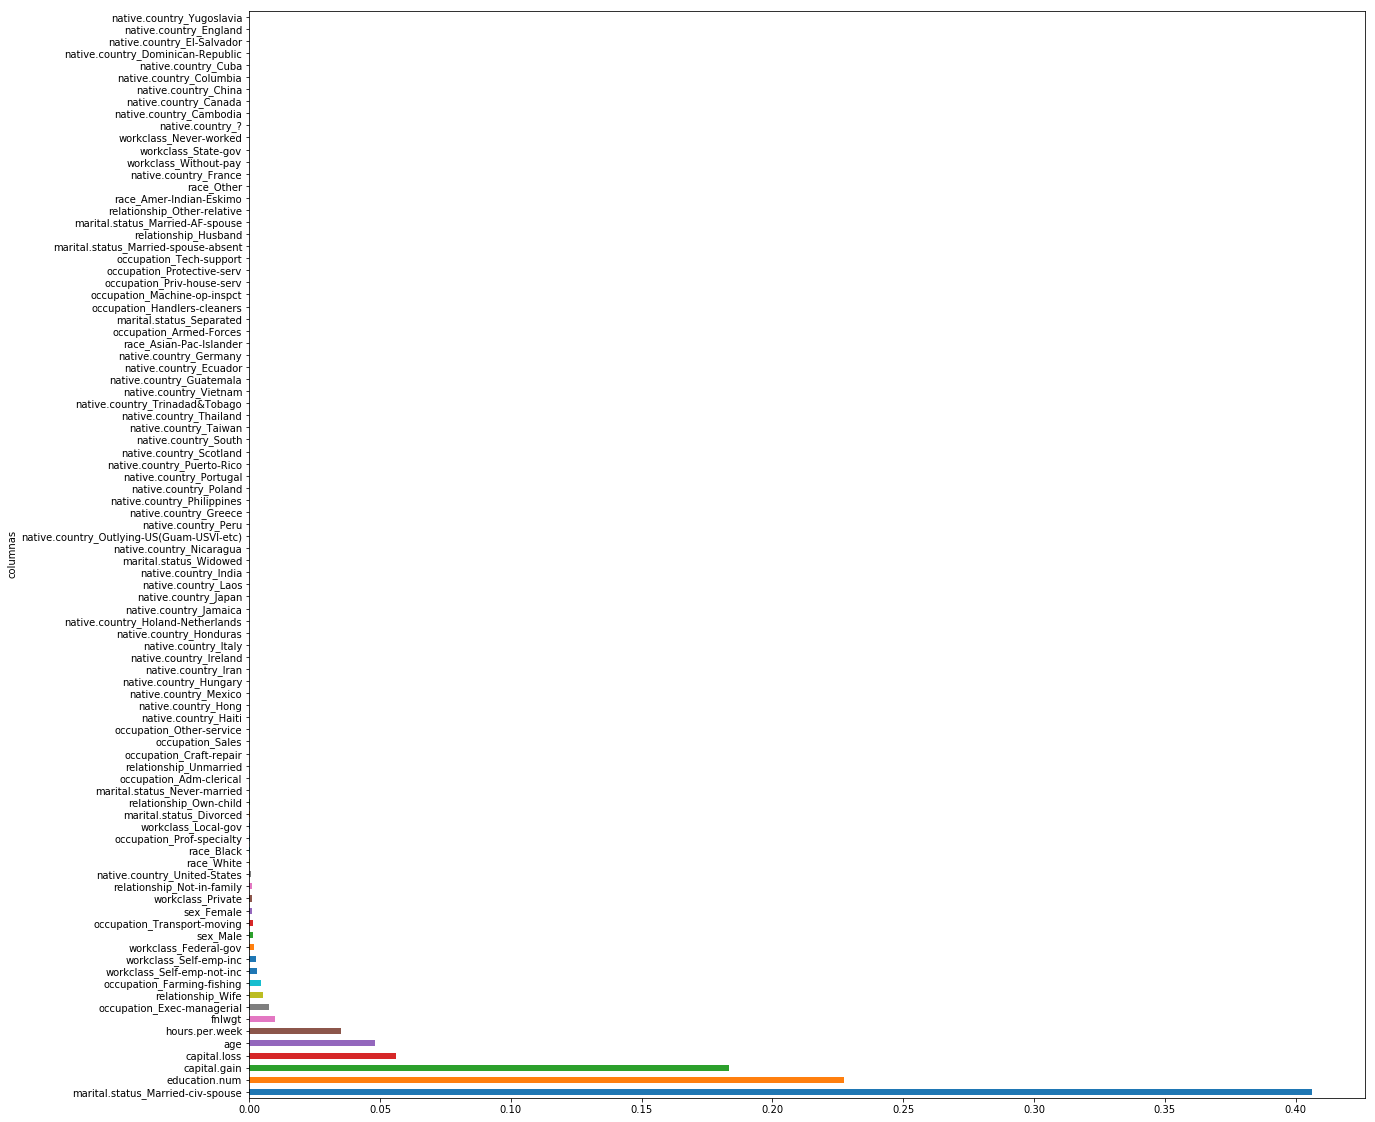

In [125]:
mDTC = DecisionTreeClassifier(max_depth=12, min_samples_split = 44, min_samples_leaf = 51, random_state = 0)
mDTC.fit(X_train, y_train)
predicciones_test = mDTC.predict(X_test)
matrizC(y_test, predicciones_test)
feat_importance = pd.DataFrame({'columnas':X.columns, 'imp':mDTC.feature_importances_}).sort_values('imp', ascending=False)
feat_importance.plot('columnas', 'imp', 'barh', figsize=(20,20), legend=False);